# Pyladies Meetup Week One: Bayes Basics

### Meant for an "after work" live presentation
This notebook is meant for a live presentation and may be confusing to follow without direct explanation. It also is a very quick treatment of Bayes Theorem for the mean for the "after work exhausted professional".

If you're interested after this tutorial I would suggest reading

* Bayesian Analysis with Python - Osvaldo Martin
* Statistical Rethinking - Richard McElreath

In [1]:
import pymc3 as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Agenda
1. Bayesian Updating Intuition
2. Intro to Bayesian Formula
    * Bayes with point probabilities
    * There's so much more than point probabilities
3. Jumping into Deep End with PyMC3 and ArviZ
4. Breaking things apart
    * Priors
    * Likelihood
    * PPLs
    * The Magic Inference Button 
    * Posterior plots
3. Turning intuition into statistics using PyMC3 and ArviZ

### Meant for an "after work" live presentation
This notebook is meant for a live presentation and may be confusing to follow without direct explanation. It also is a very quick treatment of Bayes Theorem. For some really great intros I would suggest

* Bayesian Analysis with Python - Osvaldo Martin
* Statistical Rethinking - Richard McElreath

## Exercise: Bayesian Updating Intuition 

So what is Bayesian probability theory anyway? Let's start with an exercise.

I have a deck of cards here (in real life). Pretend this deck of cards is infinite, and you'll never see every single one so you can never be sure of the exact counts.

1. Before seeing any cards in this deck, what's the proportion of black and red?
2. If I draw 5 what is your belief in the proportion of red vs black in the deck?
3. If I draw 10 what is your belief in the proportion of red vs black in the deck?
4. How do your beliefs change as you see more cards?

### For the onine reader
For those reading online, at this point I'll be

1. Drawing 0 cards from a loaded deck and asking people to guess the proportion of red vs black?
2. Drawing 5 cards and asking people to guess the proportion of red vs black?
3. Drawing 10 cards and asking people to guess the proportion of red vs black?
4. After seeing 10 cards how sure are you that the deck is
    * 0% Red
    * 100% Red
    * 50% Red
    * 20% Red
    
**Takeaways**
* As humans the more data we see the more "sure" we become about the world
* For example the more of this tutorial you see, the more you'll figure out whether you like it or not

## Intro to Bayes Formula in a hurry
*Disclaimer*: I'm largely skipping over mathematical details so we can spend more time on intuition

The mathematical for Bayes Formula looks like this.

$$
\Large
p(\theta \mid y) = \frac{ p(y \mid \theta)p(\theta)}{p(y)}
$$

The idea of updating beliefs based on new data is captured in Bayes Formula. Notably we have

* The prior $p(\theta)$ which describes the belief in the world before seeing new data  

* The likelihood $p(y \mid \theta)$ which describes the probability of the "parameter" given the data  

* The posterior $ p(\theta \mid y)$ which is the updated belief after seeing the data

* The base rate $ p(y) $ which is the probability of the thing happening. This term difficult or impossible to ascertain in many situations so Modern Bayesian approaches utilize mathematical tricks to avoid calculating this.

### For math nerds
This formula is derived from a rearranging of terms for joint probabilities:

$$
P(\theta, y) = P(\theta)P(y | \theta) = P(y)P(\theta | y)
$$


### Point probability example of Bayes Theorem (and why I don't like them)
Here's an example taken from a data science blog post (https://towardsdatascience.com/what-is-bayes-rule-bb6598d8a2fd) that poses the question *What is the probability of cancer given you're a smoker?*



So let's assume 
$P(Cancer) = .05$ (Prior)  
$P(Smoker) = .1$ (Base Rate)  
$P(Smoker | Cancer) = .2)$ (Likelihood)  

Once we know all that all we need to do it plug it into the formula!

In [2]:
p_cancer = .05
p_smoker = .1
p_smoker_given_cancer = .2

p_cancer_given_smoker = (p_smoker_given_cancer * p_cancer)/p_smoker
p_cancer_given_smoker

0.10000000000000002

So the probability of cancer prior to "conditioning" on "smoker" was .5, but after "conditioning" on smoking was .5. In other words, before I knew anything about you I estimated there was a 5% chance of getting cancer, but now I know you're a smoker I estimate there is a 10% chance of you getting cancer.

### Why point probability examples confused me at first
This "napkin" example of Bayes Theorem is simple and easily understood but it's not very practical. Let me illustrate with our card draw example.


#### Estimating range of outcomes
What do we do in non yes/no (binary) outcomes? For our card example we're interested in the proportion of red versus black cards in the deck. This isn't a yes/no question but rather a belief in a range of proportions from 0 to 1, not just the probability of a single event.

#### Incorporating other factors
Additionally what if we know something else about the patient, like sex, or whether their parents had cancer?  What if we know something that is continous like age? How do we easily incorporate this new information? With point probabilities its possible but it gets messy fairly quickly

#### How did we get the point probabilities?
Where did any of these numbers come from? How do we know the base rate, or the probability of a positive test with cancer and no cancer? In practice these numbers are typically unavailable, It's practically impossible to know the base rate of cancer of the world.

### How the practioners do it: Distributions, Inference Algorithms, and Probabalistic Programming Languages,
Modern Bayesian Practioners rarely think or express Bayes Formula as shown above. Instead there's a couple of key differences.

1. We think in distributions of parameters and/or outcome, not just point probablities
    *  We want to see all shades of gray, the world isn't black and white,
2. We use Probabalistic Programming Languages to express ourselves.
    * We want to express complicated ideas to computers with ease. Probabilities notation doesn't let us do that
3. We use some clever math tricks and computers to estimate our beliefs, even without seeing all possible outcomes
    * We want estimates of the world without having to see the entire world
    * Specifically this means we avoid calculating or estiating *p(y)* in the formula through specialized algorithms


**Takeaways**
* Look past the point probability examples. There's more to Bayes Formula
* Bayesian Statisticians typically think about all outcomes, not just one outcome
* The combination of really neat math tricks, clever programmers, and very powerful computers give modern Bayesian Statisticians a diverse toolset that simplifies the expression of "causal models"

## Jumping into the Bayesian Programmer deep end
Alright let's just for go it. Here's a fully built PyMC3 model with ArviZ posterior plots. Don't get wrapped up in the code at the moment, focus on the results an the intuition.  

In particular pay attention to the width of the distribution, and the relative height of x values different values on the y axis

### Five observations
Given 5 observations how sure are we of the proportion of red cards?

Number of Red Observations 2, Total Number of Observations 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_red]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:10<00:00, 1052.03draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c19aed198>],
      dtype=object)

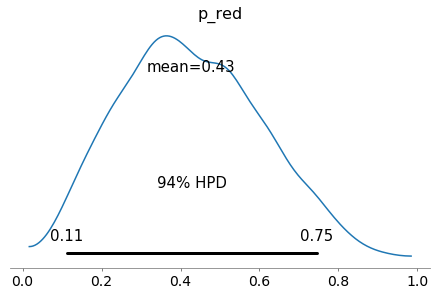

In [3]:
observations = [0, 0, 0, 1, 1]
red_observations = sum(observations)
total_observations = len(observations)
print(f"Number of Red Observations {red_observations}, Total Number of Observations {total_observations}")

with pm.Model() as five_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0, 1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    trace = pm.sample(draws=5000)
    
az.plot_posterior(trace)

### Ten observations
Given 10 observations how sure are we of the proportion of red cards?

Number of Red Observations 4, Total Number of Observations 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_red]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:13<00:00, 812.52draws/s] 


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a2f1860>],
      dtype=object)

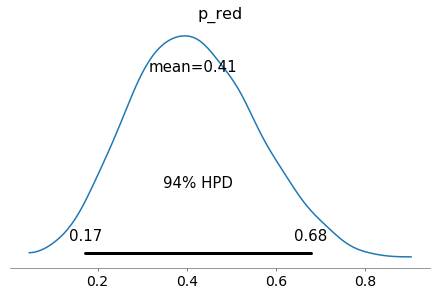

In [4]:
observations = np.tile([0, 0, 0, 1, 1],2)
red_observations = sum(observations)
total_observations = len(observations)
print(f"Number of Red Observations {red_observations}, Total Number of Observations {total_observations}")

with pm.Model() as ten_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0 ,1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    trace = pm.sample(draws=5000)

az.plot_posterior(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Number of Red Observations 40, Total Number of Observations 100


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_red]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:05<00:00, 2175.85draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a070ef0>],
      dtype=object)

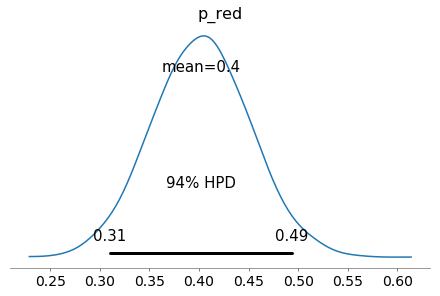

In [5]:
observations = np.tile([0, 0, 0, 1, 1], 20)
red_observations = sum(observations)
total_observations = len(observations)
print(f"Number of Red Observations {red_observations}, Total Number of Observations {total_observations}")

with pm.Model() as one_hundred_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0 ,1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    trace = pm.sample(draws=5000)

az.plot_posterior(trace)

**Takeaways**
* As the "Bayes math/computer magic" sees more data it becomes more sure
* The sureness is represented in the Posterior Distribution showing the distribution of parameters and the relative height of each
* PPLs, like PyMC3, are the interface to a whole world of computational bayes algorithms, plotting, diagnostics, just like scikit learn is for decision trees, linear regressions etc. 

# Learning how to swim in Bayes Concepts, PyMC3 and ArviZ
Now that you've seen a whole lot of Bayesian Models/Code let's break focus on each piece individually

## Step 1: Think hard about your past beliefs, how the data is generated, and distributions (before you write code)

### Picking a prior
Let's start with priors. Before seeing any cards how do we express our beliefs? Picking priors and defending priors is an important part the Bayesian Practioners workflow.

#### I have no idea (Naive prior)
"I have no idea" is called the uniform distribution. Every value of proportion of red is equally likely from 0 to 1

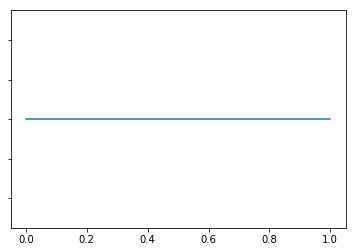

In [6]:
possible_values_of_red = np.linspace(0,1, 1000)
belief_in_parameter = np.repeat([1], 1000)

fig, ax = plt.subplots()

ax.plot(possible_values_of_red, belief_in_parameter)

# ax.axvline(.2, c="r", linestyle=':')
# ax.axvline(.5, c="r", linestyle=':')
ax.set_yticklabels([]);

#### I've seen lots of decks of cards, I'm kinda sure it's 50/50 red and black (Informed prior)

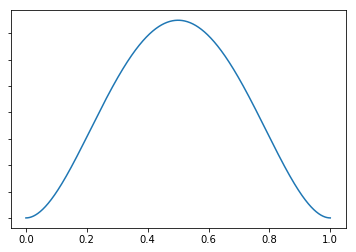

In [7]:
possible_values_of_red = np.linspace(0,1, 1000)

# Beta distributions are great at describing probabilities!
belief_in_parameter = stats.beta(3,3).pdf(possible_values_of_red)

fig, ax = plt.subplots()
ax.plot(possible_values_of_red, belief_in_parameter)

# ax.axvline(.2, c="r", linestyle=':')
# ax.axvline(.5, c="r", linestyle=':')

ax.set_yticklabels([]);

#### I've seen lots of decks of cards, I'm very sure it's 50/50 red and black (Informed prior)

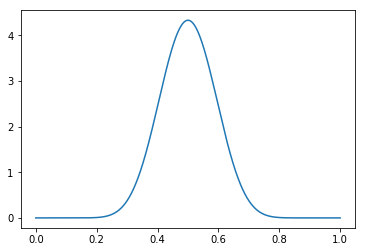

In [8]:
possible_values_of_red = np.linspace(0,1, 1000)
belief_in_parameter = stats.beta(15,15).pdf(possible_values_of_red)

fig, ax = plt.subplots()

# ax.axvline(.2, c="r", linestyle=':')
# ax.axvline(.5, c="r", linestyle=':')

ax.plot(possible_values_of_red, belief_in_parameter);

#### Every deck I've seen has had more red than black (Informed prior)

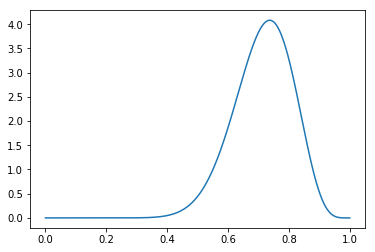

In [9]:
possible_values_of_red = np.linspace(0,1, 1000)
belief_in_parameter = stats.beta(15,6).pdf(possible_values_of_red)

fig, ax = plt.subplots()

# ax.axvline(.2, c="r", linestyle=':')
# ax.axvline(.5, c="r", linestyle=':')

ax.plot(possible_values_of_red, belief_in_parameter);

**Takeaways**
* Priors encode the belief before data from current experiment is seen
* Priors can be distributions of beliefs, not just one belief
* Choice of prior is a powerful tool in the Bayesian Workflow

### Likelihood: How was my data generated?

Our next step is to define a likelihood function. There's a rigorous math definition for likelihood, but the way we'll think about it is "How is your data generated?"


In our case the Binomial distribution describes "If there's only two possibilities for each card draw, what is the probability of reds we'll get with $p\_red$ probability".  

* $p\_red$ = 1 means you think every single card is red, so its only possible to draw red cards.
* $p\_red$ = 0 means you think no card is red, so its not possible to draw any red card. 
* $p\_red$ =.4 means you think 4 out of 10 cards are red, so some draws will be red, but most will be black. 
    
If I were estimating peoples heights I would use the Normal distribution because I know the data is continuous and likely symmetrical

If I were estimating how many people arrive at a grocery store line I would use the Poisson distribution, because that distribution exists only on natural numbers (positive integers)' and it's impossible to get -1, or 2.5 customers.

## Step 2: Expressing model using a Probabalistic Programming Language
We've seen the following data, how can estimate our belief in proportion of red?

In [10]:
# A value of 0 signifies a black card observation, a value of 1 signifies a red card observation
observations = [0, 0, 1, 0, 1]
red_observations = sum(observations)
total_observations = len(observations)

Let's recap our choice of prior and likelihood

We are trying to estimate $\theta$ where
$$\theta = \text{Proportion of red cards}$$

Your model is formulated as follows, the top line being our prior belief before seeing any data, and the bottom line being our likelihood.

$$ 
\theta \sim \operatorname{Uniform}(0,1) \\
p_{\text{red_cards}} \sim \operatorname{Binom}(\theta, N)
$$


Let's express this again in the "special" PyMC3 language. The two lines should look vaguely familiar as the prior and likelihood.

Note a couple of things:  
1. In PyMC3 we "tell" python we're building a model with the `with` context manager
2. We incorporate data into our likelihood with the `observed` argument

In [11]:
with pm.Model() as five_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0 ,1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)

The above model definition looks great, no actual inference (belief estimation) has happened yet. To do that we hit "the magic inference button" as Thomas Wiecki calls it. In PyMC3 it looks like this.

*Note*: We don't have to restate the whole model in PyMC3 but I'm choosing to do so for clarity

In [12]:
with pm.Model() as five_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0 ,1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    
    # Add Inference line
    trace_5 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_red]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:15<00:00, 719.95draws/s] 


## What is happening?

1. We express our beliefs using PPL, in particular choosing a prior and likelihood
2. PyMC3 in this case uses algorithm called Markov Chain Monte Carlo to estimate the most plausible distribution of parameters given the data. This distribution is called the posterior distribution and other algorithms can be used for posterior estimation.
3. We inspect the posterior using ArviZ to see what the math is telling us about the world
4. Feel accomplished that we used Math/Statistics/Machine Learning + Data to make an informed estimate of the world (or just this deck of cards I'm holding)

### What would a Bayesian Practioner say
We wrote down a *model* of our card draws using a *Probabalistic Programming Language*, and then using *numerical methods* to perform an *Inference* to estimate our *posterior distribution*

## Important things that we are not doing in this tutorial
* Validating MCMC convergence
* Talking about other inference methods
* Talking about model selection

# Your Turn! Fake a bunch of data. Fit distribution
A great way to understand statistical/ML algorithms is generate data, so you know the truth, then fit a model to your generated data to see what happens.

This is where you get to play around. Suggestions are

1. Generate a large amount (size=1000) at a p value of your choice. See if you can write a model to "rediscover" the parameter, using your posterior plot to find the estimated parameter
2. Change the p value and generate a large amount again. See how the posterior plot changes
3. Change your prior to different from a uniform to an informed prior and see what happens
4. Challenge: Generate a normal distribution with with a mean and standard deviation of your choice. See if you can use Bayesian inference to "find the parameters"
    * Hint: You'll need two priors, one for the mean and one for the standard deviation
    * Hint: Your likelihood will need to change from Binomial because now your data generation is charecterisic of another function

In [13]:

# This is the "hidden" truth of the world. In practice you never "observe" this value
proportion_of_red = .5

# This is the number of data points, or draws. This is what you actually observe
number_of_draws = 10
observations = stats.bernoulli(p=proportion_of_red).rvs(size=number_of_draws)

red_observations = sum(observations)
total_observations = len(observations)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_red]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:04<00:00, 2454.95draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x103837cc0>],
      dtype=object)

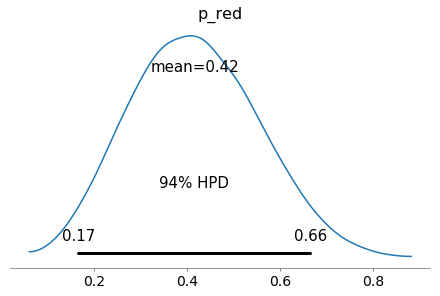

In [14]:
with pm.Model() as your_model:
    # Prior
    p_red = pm.Uniform("p_red", 0 ,1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    
    # Add Inference line
    trace = pm.sample(5000)
    
az.plot_posterior(trace)